# Linear Pathway

# Preliminaries

In [1]:
from src.surfaceAnalyzer import SurfaceAnalyzer
from common_python.ODEModel.LTIModel import LTIModel
from common_python.sympy import sympyUtil as su

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import tellurium as te
import pandas as pd
import seaborn as sn
import sympy
import os

In [2]:
NRMSE = "nrmse"  # Normalized root of the mean square error (residuals)

In [3]:
MODEL_DIR = os.path.join(os.getcwd(), "../models")

# Helper Functions

In [4]:
MODEL = """

J1: $X0 -> x; k1*X0
J2: x -> $X1; k2*x

X0 = 1
x = 0
k1 = 1
k2 = 1
"""

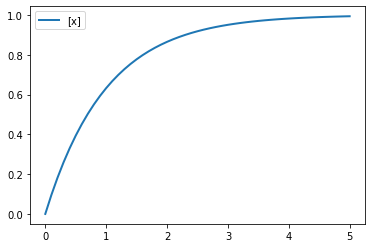

In [5]:
rr = te.loada(MODEL)
trueData = rr.simulate()
rr.plot(trueData)

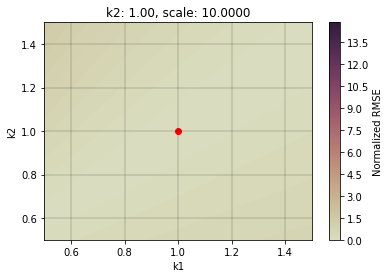

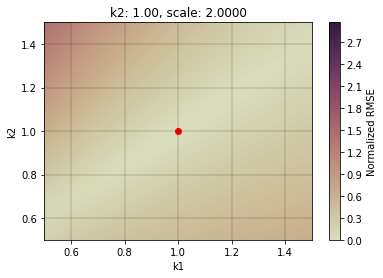

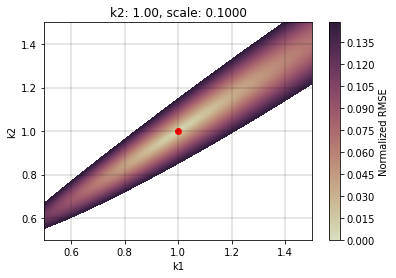

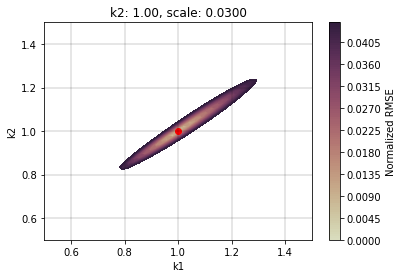

In [6]:
PARAMETER_DCT = {"k1": 1, "k2": 2}
analyzer = SurfaceAnalyzer(MODEL, PARAMETER_DCT)
scales = [10, 2, 0.1, 0.03]
k2s = [0.5, 1.0, 2.0]
k2s = [1.0]
for scale in scales:
    for k2 in k2s:
        parameterDct = dict(PARAMETER_DCT)
        parameterDct["k2"] = k2
        analyzer = SurfaceAnalyzer(MODEL, parameterDct)
        analyzer.runExperiments(0.5, 50)
        title = "k2: %2.2f, scale: %2.4f" % (k2, scale)
        analyzer.plotSurface(scale=scale, title=title, xlim=[0.5, 1.5], ylim=[0.5, 1.5])

# Constructing Linear Pathway Models

In [7]:
def mkParameterName(num):
    return "k%d" % num

#TESTS
name = mkParameterName(1)
assert(isinstance(name, str))
assert(len(name) == 2)

In [8]:
def mkRandomParameterDct(numReaction, minValue=0.1, maxValue=100):
    """
    Constructs the parameter dictionary for a linear pathway with random parameter values.
    """
    return {mkParameterName(idx): np.random.uniform(minValue, maxValue) for idx in range(numReaction)}

# TESTS
dct = mkRandomParameterDct(3)
assert(len(dct) == 3)
assert(isinstance(dct, dict))

In [9]:
def mkFixedParameterDct(numReaction, value=1):
    """
    Constructs the parameter dictionary for a linear pathway with fixed parameter values.
    """
    return {mkParameterName(idx): value for idx in range(numReaction)}

# TESTS
dct = mkFixedParameterDct(3)
assert(len(dct) == 3)
assert(isinstance(dct, dict))

// Model with 2 reactions

// Reactions
S0 -> S1; k0*S0
S1 -> $S2; k1*S1

// Parameter Initializations
k0 = 1
k1 = 2

// Species Initializations
S0 = 10
S1 = 0


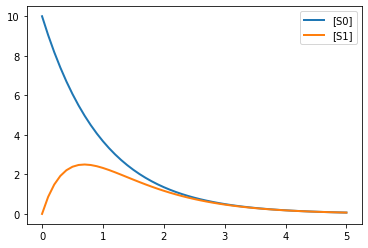

In [10]:
def mkModel(parameterDct, speciesDct=None, isFirstFixed=True, isLastFixed=True, fixedSpeciesValue=10):
    """
    Creates an antimony model for a linear pathway.
    The number of reactions is len(parameterDct).
    Species are named "S*". There is one more species than reaction.
    """
    def mkInitializations(dct):
        """
        Constructs initializations for the name, value pairs.
        
        Parameters
        ----------
        dct: dict
        
        Returns
        -------
        list-str
        """
        initializations = []
        for name, value in dct.items():
            assignment = "%s = %s" % (name, str(value))
            initializations.append(assignment)
        return initializations
    #
    def mkSpecies(num):
        if isFirstFixed and (num == 0):
            prefix = "$"
        elif isLastFixed and (num == len(parameterDct)):
            prefix = "$"
        else:
            prefix = ""
        return "%sS%d" % (prefix, num)
    #
    if speciesDct is None:
        speciesDct = {mkSpecies(n): fixedSpeciesValue if n == 0 else 0 
                      for n in range(len(parameterDct))}
    #
    numReaction = len(parameterDct)
    parameters = list(parameterDct.keys())
    reactions = []
    # Construct the reactions
    for idx in range(numReaction):
        reactant = mkSpecies(idx)
        product = mkSpecies(idx + 1)
        kinetics = "%s*%s" % (parameters[idx], reactant)
        reaction = "%s -> %s; %s" % (reactant, product, kinetics)
        reactions.append(reaction)
    # Initialtion statements
    parameterInitializations = mkInitializations(parameterDct)
    speciesInitializations = mkInitializations(speciesDct)
    # Assemble the model
    model = "// Model with %d reactions\n\n" % numReaction
    model = model + "// Reactions\n"
    model = model + "\n".join(reactions)
    model = model + "\n\n// Parameter Initializations\n"
    model = model + "\n".join(parameterInitializations)
    model = model + "\n\n// Species Initializations\n"
    model = model + "\n".join(speciesInitializations)
    return model

# Tests
model = mkModel({"k0": 1, "k1": 2}, isFirstFixed=False)
print(model)
rr = te.loada(model)
rr.plot(rr.simulate())

# Numerical Studies

In [14]:
def analyzeModel(numReaction, parameterValue=1, fixedSpeciesValue=1, isPlot=True):
    parameterDct = mkFixedParameterDct(numReaction, value=parameterValue)
    model = mkModel(parameterDct, fixedSpeciesValue=fixedSpeciesValue)
    analyzer = SurfaceAnalyzer(model, parameterDct)
    analyzer.runExperiments(0.5, 50)
    analyzer.plotSurface(isPlot=isPlot)
    return analyzer
    
# TESTS
analyzer = analyzeModel(2, isPlot=False)
assert(isinstance(analyzer, SurfaceAnalyzer))

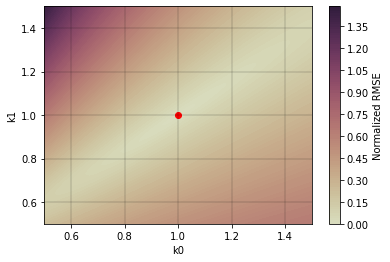

KeyboardInterrupt: 

In [15]:
for numReaction in range(2, 10):
    analyzeModel(numReaction)